$\Huge Computational$ $\Huge Intelligence$ $\Huge Lab$

$\Huge  Assignment$ $\Huge 4$
---
Piotr Cenda, gr 1b
---

# 4.1 Introduction - dedicated layers for image augmentation

*  Perform various image transformations (rotation, flipping, croping, scaling)
*  Parameters specify ranges of transformations
*  Can be used as functions (eagerly) - executed on the host
*  Can be used as network layers  - executed as a computational graph (possibly on GPU)

<Response [200]>


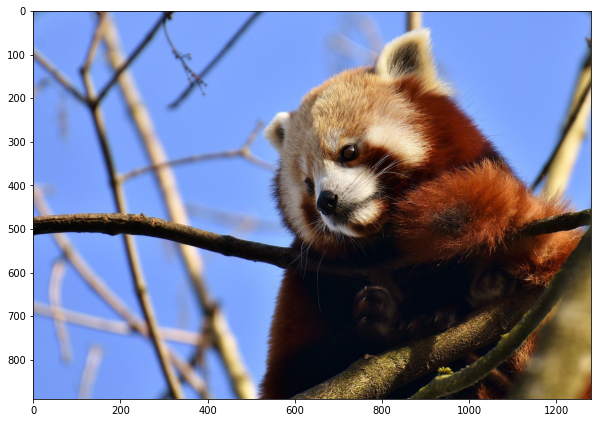

In [1]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5, 5) 


url='https://cdn.pixabay.com/photo/2018/02/18/00/22/panda-3161290_1280.jpg'
response = requests.get(url)
print(response)
img = Image.open(BytesIO(response.content))

plt.rcParams['figure.figsize'] = (10, 10) 
_ = plt.imshow(img)



In [2]:
import numpy as np
import tensorflow as tf
from keras import layers
from keras import models

X = np.array(img)

**Function displaying a few images after conversion**

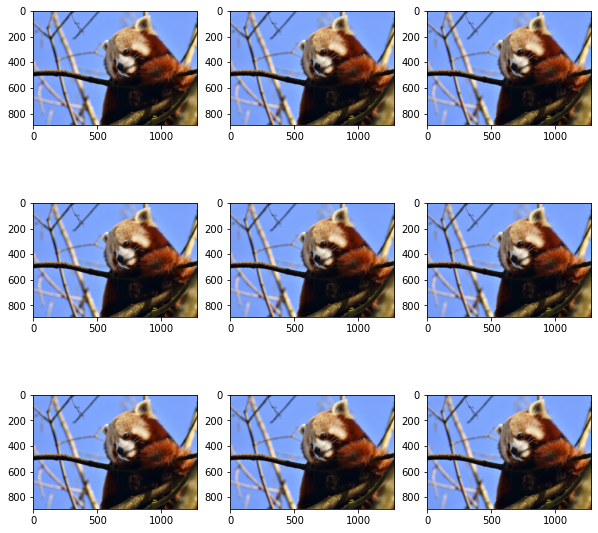

In [3]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

def display(X, converter, title=None):
  for i in range(9):
    ax = plt.subplot(330 + 1 + i)
    converted_image  = converter(X)
    plt.imshow(converted_image)
  if title is not None:
    plt.suptitle(title)
  plt.show()

display(X, lambda a:a)

## RandomContrast

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


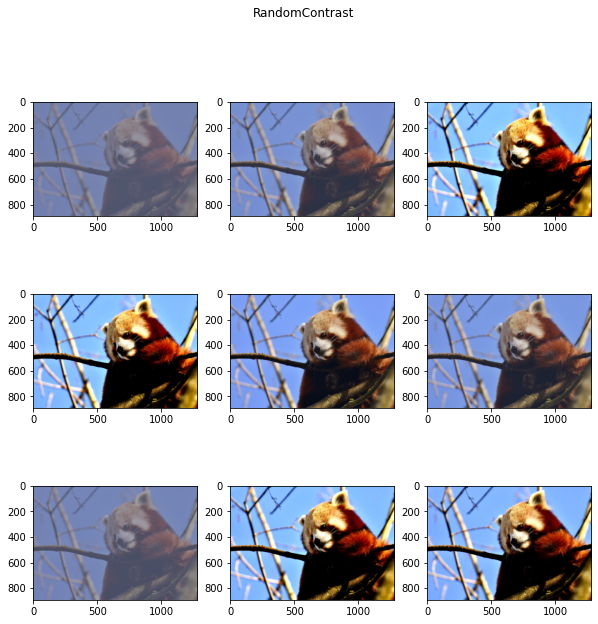

In [4]:
converter = models.Sequential([
  layers.RandomContrast(.8, seed=1),
  layers.Rescaling(1./255)
])

display(X, converter, title='RandomContrast')

## Test more converters


=========== RandomCrop ============


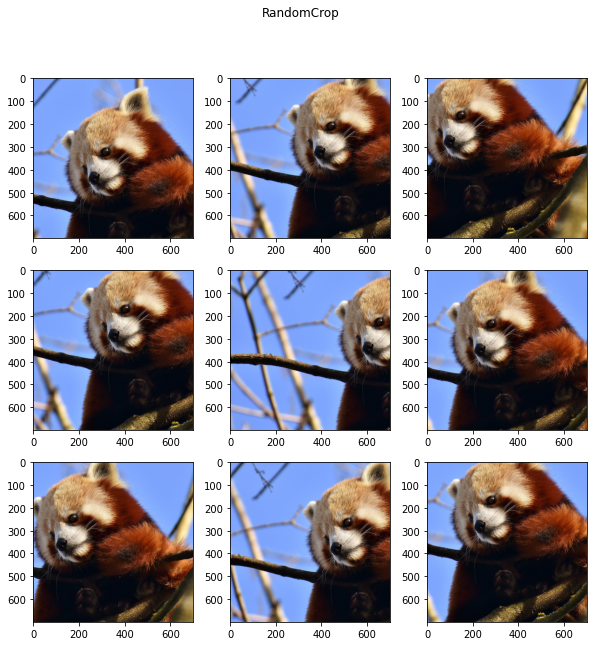


=========== RandomFlip ============


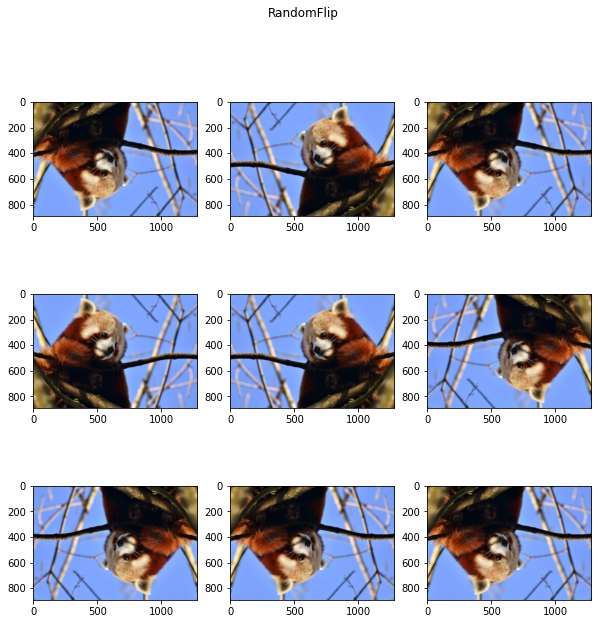


=========== RandomHeight ============


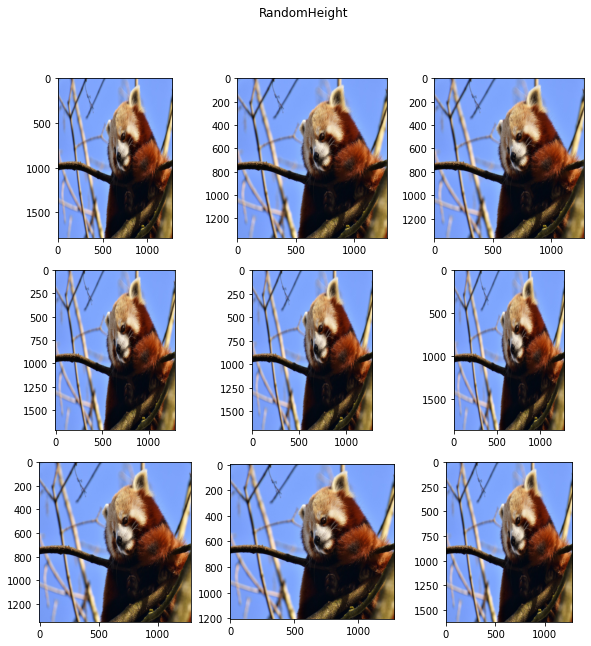


=========== RandomWidth ============


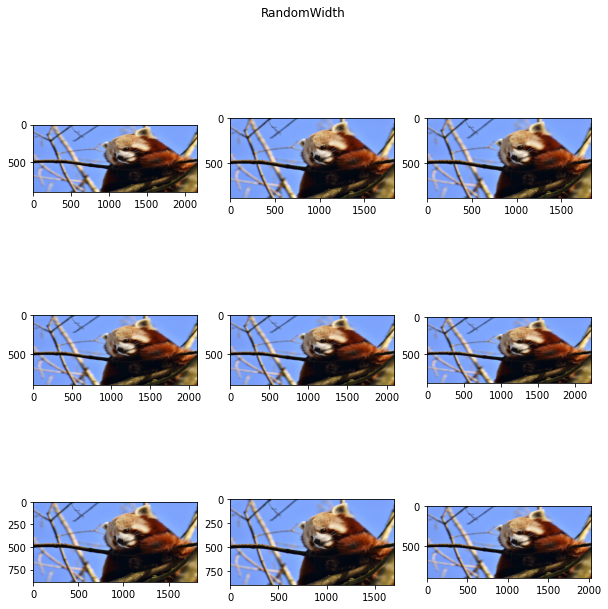


=========== RandomRotation ============


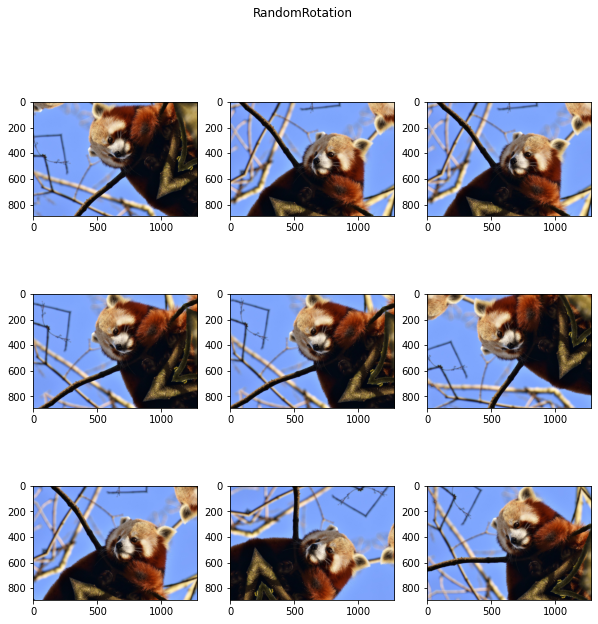


=========== RandomTranslation ============


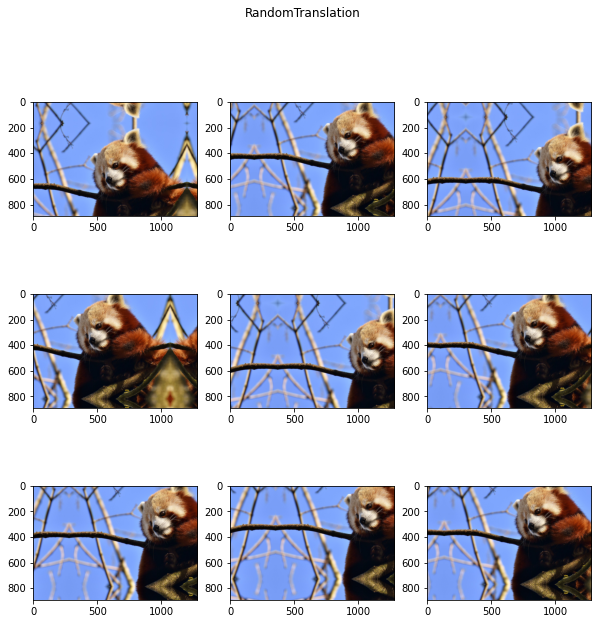


=========== RandomZoom ============


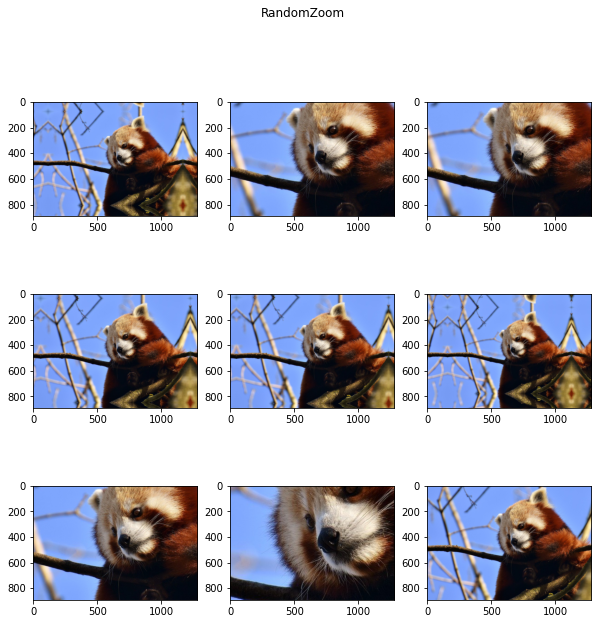

In [5]:
preprocessing_layers = [
    layers.RandomCrop(height=700, width=700, seed=1),
    layers.RandomFlip(mode="horizontal_and_vertical", seed=1),
    layers.RandomHeight(factor=(0.3,1.2), seed=1),
    layers.RandomWidth(factor=(0.3,0.8), seed=1),
    layers.RandomRotation((-0.25,0.25), seed=1),
    layers.RandomTranslation(height_factor=(-0.2, 0.3), width_factor=(-0.2, 0.3), seed=1),
    layers.RandomZoom(height_factor=(-0.8,.5), seed=1)                     
]

for pl in preprocessing_layers:
  print()
  print(f'=========== {pl.__class__.__name__} ============')
  converter = models.Sequential([
    pl,
    layers.Rescaling(1./255)
  ])
  display(X,converter,title=pl.__class__.__name__)

# 4.2 Horses or humans

We will use  [horses_or_humans](https://www.tensorflow.org/datasets/catalog/horses_or_humans) tensorflow dataset.

The TF daset API returns data wrapped as [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) object. 

tf.data.Dataset can be considered an equivalent to Java stream. It provides such operations as mapping, filtering, limiting, shuffling and skipping data. It is also reponsible for formation of batches. 

Dataset is intended to execute on CPU in parallel with training on GPU. While the network is trained using data in a current batch, a next batch is fetched and prepared for delivery.

In [54]:
import tensorflow_datasets as tfds
import tensorflow as tf

ds_train = tfds.load('horses_or_humans', split='train', as_supervised=True, shuffle_files=False)
ds_test = tfds.load('horses_or_humans', split='test', as_supervised=True, shuffle_files=False)
val_dataset, val_info = tfds.load("horses_or_humans", with_info=True, split='test', as_supervised=True)

In [55]:
# How many elements?
print(f'Number of images in train set: {ds_train.cardinality()}')
print(f'Number of images in test set: {ds_test.cardinality()}')

Number of images in train set: 1027
Number of images in test set: 256


In [56]:
# How many classes

labels = [label.numpy() for image, label in ds_train]
num_classes = max(labels)+1
print(f'#classes = {num_classes}')

#classes = 2


In [57]:
# image shapes?

images = [image.numpy() for image, label in ds_train.take(10)] # first 10 images
for img in images:
  print(f'shape={img.shape}')

shape=(300, 300, 3)
shape=(300, 300, 3)
shape=(300, 300, 3)
shape=(300, 300, 3)
shape=(300, 300, 3)
shape=(300, 300, 3)
shape=(300, 300, 3)
shape=(300, 300, 3)
shape=(300, 300, 3)
shape=(300, 300, 3)


### Display a few images

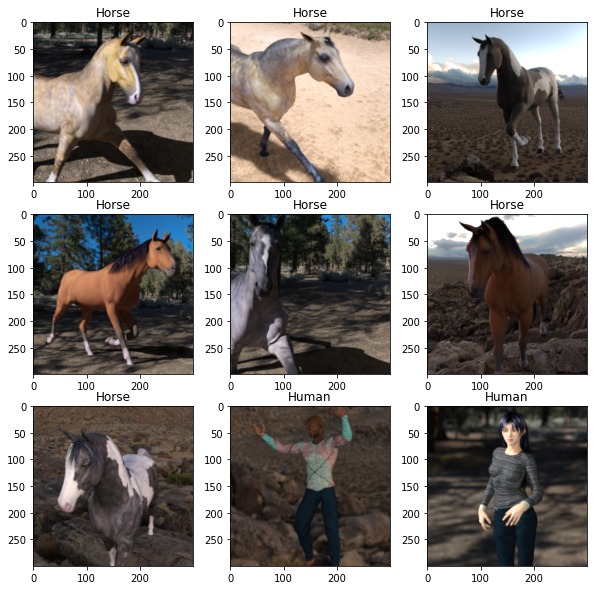

In [10]:
#display a few images...
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 10) 

ds2 = ds_train.take(9) # take - equivalent of limit
it = ds2.as_numpy_iterator()

labels=['Horse','Human']
input_size=100
for i in range(9):
  ax = plt.subplot(330 + 1 + i)
  image, label = next(it)
  ax.set_title(labels[label])
  plt.imshow(image)
plt.show()

### Apply sample transformations

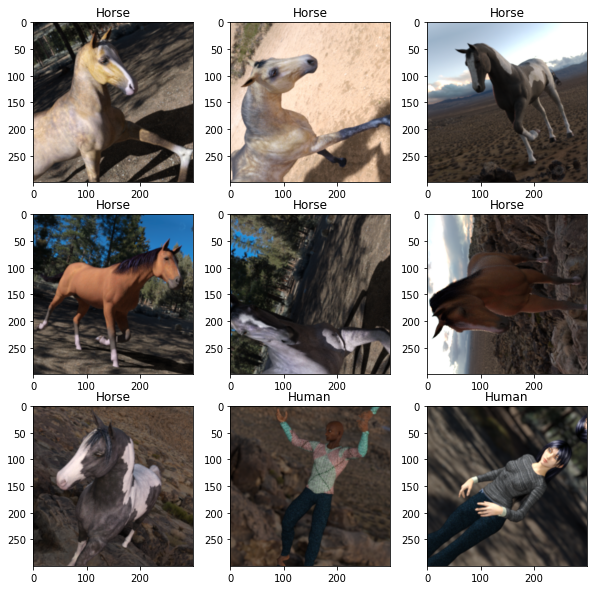

In [11]:
rotate = layers.RandomRotation((-0.25,0.25), seed=123)
rescale = layers.Rescaling(1./255)
ds2 = ds_train.take(9).map(lambda x,y: (rescale(rotate(x)), y)) #<<<<< rotate then rescale
it = ds2.as_numpy_iterator()


labels=['Horse','Human']
input_size=100
for i in range(9):
  ax = plt.subplot(330 + 1 + i)
  image, label = next(it)
  ax.set_title(labels[label])
  plt.imshow(image)
plt.show()

## 4.2.1 Classification (no augmentation)
**TODO 4.2.1** Propose your own model consisting of a few Conv2D, MaxPooling2D and (optionaly) dropout layers. Then Flatten, Dense. As this is a binary classification problem - you may use one (sigmoid) or two (softmax) neurons in the output layer. Please observe: the shape of input layer must match the shapes of images.

In [58]:
from keras import layers
from keras import models
from keras import optimizers
from keras import regularizers

image_width = 300
image_height = 300

def get_classifier_model():
  classifier_model = models.Sequential([
    layers.Conv2D(16, (5,5), activation='relu', input_shape=(image_height, image_width, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.15),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.15),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax') 
    ])
  return classifier_model


### Configuration of Dataset streams


In [59]:
def prepare_dataset(ds, batch_size=16, resize=None, augment=None):
  if resize is not None:
    ds = ds.map(lambda x, y: (resize(x), y), 
              num_parallel_calls=tf.data.AUTOTUNE)
  
  ds = ds.shuffle(1000)
  ds = ds.batch(batch_size)

  if augment is not None:
    ds = ds.map(lambda x, y: (augment(x), y), 
              num_parallel_calls=tf.data.AUTOTUNE)
    
  return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

ds_train_preprocessed = prepare_dataset(ds_train)
ds_test_preprocessed = prepare_dataset(ds_test)


### Training

In [15]:
classifier_model = get_classifier_model()

classifier_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
              metrics=['accuracy'])
classifier_model.summary()

epochs = 20
hist = classifier_model.fit(ds_train_preprocessed, epochs=epochs, validation_data=val_dataset.batch(16))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 296, 296, 16)      1216      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 148, 148, 16)     0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 148, 148, 16)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 146, 146, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 73, 73, 32)       

### Evaluate results

In [16]:
loss, acc = classifier_model.evaluate(ds_test_preprocessed)
print("Accuracy", acc)

16/16 [==============================] - 1s 29ms/step - loss: 4.3914 - accuracy: 0.7969
Accuracy 0.796875


## 4.2.2. Augmentation on host
In this setup images will be transformed during operations performed by tf.data.Dataset. Batch data can be prepared in parallel by multiple CPU threads.

**TODO 4.2.2** Design your own transformations sequence consisting of at least two steps (apart from resizing and rescaling). Avoid shots that are not likely to occur. Rather introduce small modifications...

In [17]:
image_width = 300
image_height = 300

transform = models.Sequential([
  layers.RandomFlip(mode="horizontal", seed=1),
  layers.RandomTranslation(height_factor=(-0.2, 0.3), width_factor=(-0.2, 0.3), seed=1),
  layers.RandomRotation((-0.25,0.25), seed=1),
  layers.RandomZoom(height_factor=(-0.8,.5), seed=1),
  layers.Resizing(image_width, image_height),
  layers.Rescaling(scale=1./255)
])

resize = models.Sequential([
  layers.Resizing(image_width, image_height),
  layers.Rescaling(scale=1./255)
])


**Augmentation is applied to ds_train. Test data are not transformed.**

In [18]:
ds_train_preprocessed = prepare_dataset(ds_train, augment=transform)
ds_test_preprocessed = prepare_dataset(ds_test)

**TODO 4.2.3** Compile, fit during 20 epochs and evaluate results

In [19]:
classifier_model = get_classifier_model()

classifier_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
              metrics=['accuracy'])

classifier_model.summary()

epochs = 20
hist = classifier_model.fit(ds_train_preprocessed, epochs=epochs, validation_data=val_dataset.batch(16))

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 296, 296, 16)      1216      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 148, 148, 16)     0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 148, 148, 16)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 146, 146, 32)      4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 73, 73, 32)      

In [20]:
loss, acc = classifier_model.evaluate(ds_test_preprocessed)
print("Accuracy", acc)

16/16 [==============================] - 1s 27ms/step - loss: 336.2774 - accuracy: 0.8555
Accuracy 0.85546875


## 4.2.3 Augmentation on GPU

In this case transformation layers are part of the model. We compose the model from two submodels: transform and classifier_model. 

Data augmentation step is not included into Dataset stream.

In [60]:
classifier_model = get_classifier_model()

full_model = models.Sequential([
  transform,
  classifier_model
])

ds_train_preprocessed = prepare_dataset(ds_train)
ds_test_preprocessed = prepare_dataset(ds_test)

**TODO 4.2.4** Compile full_model, train during 20 epochs? Compute accuracy on the tets set.

In [62]:
full_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
              metrics=['accuracy'])

epochs = 20
hist = full_model.fit(ds_train_preprocessed, epochs=epochs, validation_data=val_dataset.batch(16))

Epoch 1/20
65/65 [==============================] - 13s 86ms/step - loss: 1.1362 - accuracy: 0.4761 - val_loss: 0.9859 - val_accuracy: 0.5000
Epoch 2/20
65/65 [==============================] - 9s 84ms/step - loss: 0.9553 - accuracy: 0.5024 - val_loss: 0.9281 - val_accuracy: 0.5000
Epoch 3/20
65/65 [==============================] - 9s 85ms/step - loss: 0.9637 - accuracy: 0.5083 - val_loss: 0.9850 - val_accuracy: 0.5000
Epoch 4/20
65/65 [==============================] - 9s 84ms/step - loss: 0.9881 - accuracy: 0.4976 - val_loss: 1.0175 - val_accuracy: 0.5000
Epoch 5/20
65/65 [==============================] - 9s 84ms/step - loss: 0.9624 - accuracy: 0.5083 - val_loss: 0.9719 - val_accuracy: 0.5000
Epoch 6/20
65/65 [==============================] - 9s 83ms/step - loss: 0.9616 - accuracy: 0.5209 - val_loss: 0.9521 - val_accuracy: 0.6016
Epoch 7/20
65/65 [==============================] - 9s 83ms/step - loss: 0.9431 - accuracy: 0.5862 - val_loss: 0.9217 - val_accuracy: 0.7305
Epoch 8/20
6

In [63]:
loss, acc = full_model.evaluate(ds_test_preprocessed)
print("Accuracy", acc)

16/16 [==============================] - 1s 25ms/step - loss: 1.3118 - accuracy: 0.5000
Accuracy 0.5


**TODO 4.2.5** Data augmentation introduces noise, continue training and check accuracy

In [64]:
epochs=80
hist = full_model.fit(ds_train_preprocessed, epochs=epochs, validation_data=val_dataset.batch(16))

Epoch 1/80
65/65 [==============================] - 9s 84ms/step - loss: 0.8055 - accuracy: 0.7848 - val_loss: 2.2656 - val_accuracy: 0.5234
Epoch 2/80
65/65 [==============================] - 9s 83ms/step - loss: 0.8292 - accuracy: 0.7517 - val_loss: 1.1470 - val_accuracy: 0.5078
Epoch 3/80
65/65 [==============================] - 9s 85ms/step - loss: 0.8228 - accuracy: 0.7877 - val_loss: 2.5893 - val_accuracy: 0.5469
Epoch 4/80
65/65 [==============================] - 9s 83ms/step - loss: 0.8336 - accuracy: 0.7653 - val_loss: 1.5477 - val_accuracy: 0.5000
Epoch 5/80
65/65 [==============================] - 9s 83ms/step - loss: 0.7943 - accuracy: 0.7858 - val_loss: 1.1702 - val_accuracy: 0.6562
Epoch 6/80
65/65 [==============================] - 9s 84ms/step - loss: 0.8009 - accuracy: 0.7848 - val_loss: 1.4513 - val_accuracy: 0.6445
Epoch 7/80
65/65 [==============================] - 9s 84ms/step - loss: 0.8025 - accuracy: 0.7848 - val_loss: 0.7758 - val_accuracy: 0.7383
Epoch 8/80
65

In [65]:
loss, acc = full_model.evaluate(ds_test_preprocessed)
print("Accuracy", acc)

16/16 [==============================] - 1s 25ms/step - loss: 1.2915 - accuracy: 0.7383
Accuracy 0.73828125


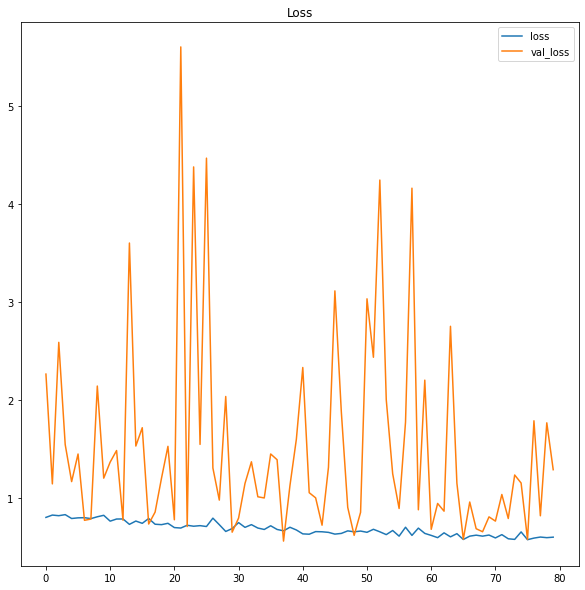

In [66]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

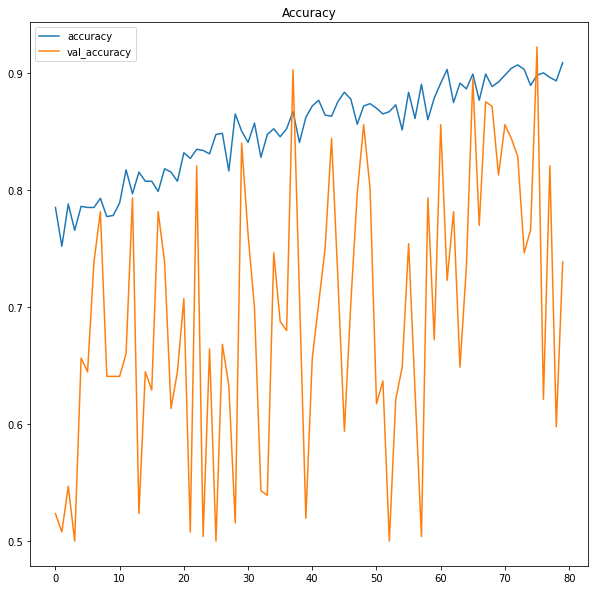

In [67]:
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

# 4.3 Imagenette

[Imagenette](https://github.com/fastai/imagenette) is a subset of Imagenet containing dataset of *easy* to classify images. We will use a variant named *imagenette/320px*, which contains images resized to 320 pixels (the shorter side). 

**Remark: sizes of images in the dataset vary** To be delivered to a neural network, images must have fixed dimensions. 

 

In [28]:
import tensorflow_datasets as tfds
import tensorflow as tf


ds_train = tfds.load('imagenette/320px', split='train', as_supervised=True, shuffle_files=False)
ds_test = tfds.load('imagenette/320px', split='validation', as_supervised=True, shuffle_files=False)


In [29]:
print(f'Number of images in train set: {ds_train.cardinality()}')
print(f'Number of images in test set: {ds_test.cardinality()}')

Number of images in train set: 12894
Number of images in test set: 500


In [30]:
labels = [label.numpy() for _, label in ds_train]
print(max(labels)+1)
num_classes = max(labels)+1

10


In [31]:
#image sizes?

ds_tmp = ds_train.take(10)
for img,label in ds_tmp:
  print(img.shape)

(320, 396, 3)
(320, 426, 3)
(320, 477, 3)
(320, 372, 3)
(320, 445, 3)
(320, 440, 3)
(320, 426, 3)
(479, 320, 3)
(480, 320, 3)
(381, 320, 3)


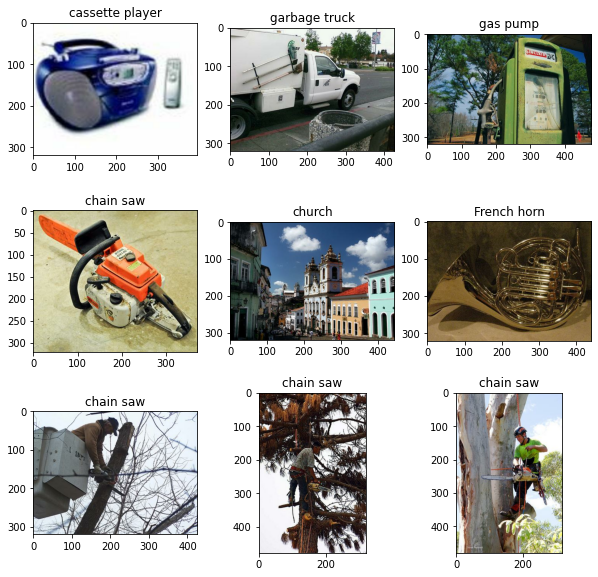

In [32]:
#display a few images...
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
labels=['tench', 'English springer', 'cassette player', 'chain saw', 'church', 
        'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']
ds2 = ds_train.take(9)
it = ds2.as_numpy_iterator()

input_size=100
for i in range(9):
  ax = plt.subplot(330 + 1 + i)
  image, label = next(it)
  # image = tf.image.resize(image, size=[256,256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  ax.set_title(labels[label])
  plt.imshow(image)
plt.show()

**TODO 4.3.1** Select a transformation that assures equal dimensions of all images (delivered to the neural network). Display images after the transformation.

In [33]:
from keras import layers
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf

transform2 = models.Sequential([
  layers.RandomFlip(mode="horizontal", seed=1),
  layers.RandomTranslation(height_factor=(-0.2, 0.3), width_factor=(-0.2, 0.3), seed=1),
  layers.RandomRotation((-0.25,0.25), seed=1),
  layers.RandomZoom(height_factor=(-0.8,.5), seed=1),
  layers.Resizing(320, 320),
  layers.Rescaling(1./255)
])

resize2 = models.Sequential([
  layers.Resizing(320, 320),
  layers.Rescaling(scale=1./255)
])

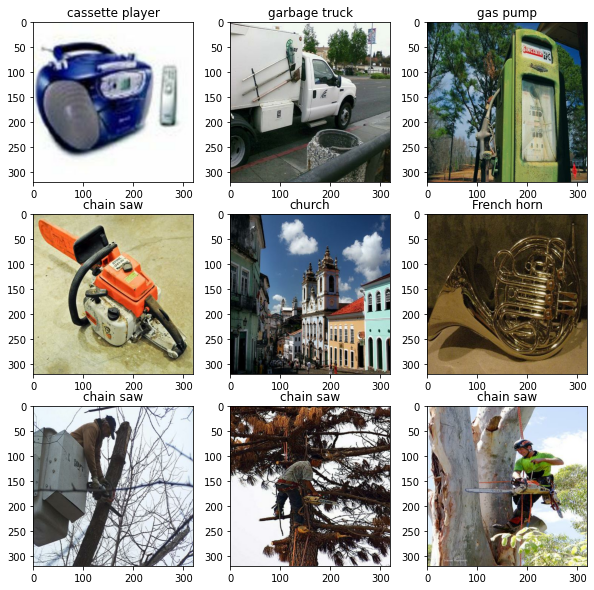

In [34]:
#display a few images...
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

labels=['tench', 'English springer', 'cassette player', 'chain saw', 'church', 
        'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']

ds2 = ds_train.take(9)
ds2 = ds2.map(lambda x, y: (transform2(x), y))
it = ds2.as_numpy_iterator()

input_size=100
for i in range(9):
  ax = plt.subplot(330 + 1 + i)
  image, label = next(it)
  # image = tf.image.resize(image, size=[256,256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  ax.set_title(labels[label])
  plt.imshow(image)
plt.show()

## 4.3.1 CNN classifier

**TODO 4.3.2** Define a CNN model comprising several convolution and max pooling layers. As there are 10 classes, the model should have 10 output neurons.

In [35]:
from keras import layers
from keras import models
from keras import optimizers

image_width = 320
image_height = 320
num_classes = 10

classifier_model = models.Sequential([
  layers.Conv2D(16, (3,3), activation='relu', input_shape=(image_height, image_width, 3)),
  layers.MaxPooling2D(2, 2),
  layers.Dropout(0.15),
  layers.Conv2D(32, (3,3), activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.Dropout(0.15),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.Dropout(0.2),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.Dropout(0.25),
  layers.Conv2D(128, (3,3), activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)),
  layers.Dropout(0.3),
  layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)),
  layers.Dropout(0.3),
  layers.Dense(num_classes, activation='softmax') 
  ])


**TODO 4.3.3** Prepare datasets. Assure identical dimensions of images.

In [36]:
def prepare_dataset(ds,batch_size=64,resize=None, augment=None):
  if resize is not None:
    ds = ds.map(lambda x, y: (resize(x), y), 
              num_parallel_calls=tf.data.AUTOTUNE)
  
  ds = ds.shuffle(1000)
  ds = ds.batch(batch_size)

  if augment is not None:
    ds = ds.map(lambda x, y: (augment(x), y), 
              num_parallel_calls=tf.data.AUTOTUNE)
    
  return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

ds_train_preprocessed = prepare_dataset(ds_train, batch_size=128, resize=resize2)
ds_test_preprocessed = prepare_dataset(ds_test, batch_size=128, resize=resize2)

**Compile** the model

In [37]:
classifier_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
              metrics=['accuracy'])
classifier_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 318, 318, 16)      448       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 159, 159, 16)     0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 159, 159, 16)      0         
                                                                 
 conv2d_17 (Conv2D)          (None, 157, 157, 32)      4640      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 78, 78, 32)       0         
 g2D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 78, 78, 32)      

...and train

In [38]:
epochs = 20
hist = classifier_model.fit(ds_train_preprocessed, epochs=epochs, batch_size=128, validation_data=ds_test_preprocessed)

Epoch 1/20
101/101 [==============================] - 60s 519ms/step - loss: 4.0848 - accuracy: 0.1253 - val_loss: 2.9275 - val_accuracy: 0.1920
Epoch 2/20
101/101 [==============================] - 51s 482ms/step - loss: 2.8778 - accuracy: 0.1983 - val_loss: 2.7640 - val_accuracy: 0.2980
Epoch 3/20
101/101 [==============================] - 51s 477ms/step - loss: 2.7485 - accuracy: 0.2296 - val_loss: 2.6743 - val_accuracy: 0.2740
Epoch 4/20
101/101 [==============================] - 51s 482ms/step - loss: 2.6636 - accuracy: 0.2667 - val_loss: 2.4987 - val_accuracy: 0.3680
Epoch 5/20
101/101 [==============================] - 53s 497ms/step - loss: 2.5869 - accuracy: 0.3094 - val_loss: 2.5295 - val_accuracy: 0.2820
Epoch 6/20
101/101 [==============================] - 51s 486ms/step - loss: 2.5277 - accuracy: 0.3357 - val_loss: 2.3556 - val_accuracy: 0.4160
Epoch 7/20
101/101 [==============================] - 51s 480ms/step - loss: 2.4748 - accuracy: 0.3644 - val_loss: 2.3314 - val_ac

**TODO 4.3.3** Compute accuracy

In [39]:
loss, acc = classifier_model.evaluate(ds_test_preprocessed)
print("Accuracy", acc)

4/4 [==============================] - 2s 205ms/step - loss: 2.0288 - accuracy: 0.5460
Accuracy 0.5460000038146973


In [40]:
classifier_model.save('imagenette_cnn.h5')

## 4.3.2 Transfer learning
*  We will use pretrained vgg16 model for **feature extraction**. 
*  Than we will flatten features to a vector form and add hidden dense layer
*  Finally, size of the output layer will correspond to the number of classes

In [41]:
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras import Sequential

from keras.applications.vgg16 import VGG16
from keras.models import Model

def define_vgg16_model():
  # load model
  model = VGG16(include_top=False, input_shape=(320, 320, 3))
  # mark loaded layers as not trainable
  for layer in model.layers:
    layer.trainable = False
  # add new classifier layers
  full_model = models.Sequential([
      model,
      Flatten(),
      Dense(128, activation='relu', kernel_initializer='he_uniform'),
      Dense(num_classes, activation='softmax')
      ])
  
  full_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  
  return full_model

model = define_vgg16_model()

58900480/58889256 [==============================] - 1s 0us/step


**TODO 4.3.4** Train the model and compute accuracy on the test data

In [42]:
epochs = 2
hist = model.fit(ds_train_preprocessed, epochs=epochs, batch_size=128, validation_data=ds_test_preprocessed)

Epoch 1/2
101/101 [==============================] - 312s 3s/step - loss: 1.5369 - accuracy: 0.7189 - val_loss: 0.3568 - val_accuracy: 0.8980
Epoch 2/2
101/101 [==============================] - 229s 2s/step - loss: 0.2564 - accuracy: 0.9290 - val_loss: 0.2563 - val_accuracy: 0.9300


In [43]:
loss, acc = model.evaluate(ds_test_preprocessed)
print("Accuracy", acc)

4/4 [==============================] - 10s 2s/step - loss: 0.2563 - accuracy: 0.9300
Accuracy 0.9300000071525574


In [44]:
model.save('imaginette_vgg16.h5')

### Compute scores and confusion matrix

We need true labels (y_test) and predictions (y_pred)

In [45]:
y_test = [label.numpy() for img,label in ds_test]
y_test = np.array(y_test)
y_test.shape

(500,)

In [46]:
import numpy as np
probs = model.predict(ds_test_preprocessed)
print(f'{probs.shape}')
y_pred = np.argmax(probs, axis=1)

(500, 10)


In [47]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt


# Define the confusion matrix for the results
def show_confusion_matrix(matrix, labels=None):
    num_classes = matrix.shape[0]
    if labels is None:
      labels = [str(i) for i in range(num_classes)]
    plt.figure(figsize=(num_classes, num_classes))
    hm = sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=labels[0:num_classes],
                yticklabels=labels[0:num_classes],
                annot=True,
                fmt='d')
    plt.yticks(rotation = 0)  # Don't rotate (vertically) the y-axis labels
    # hm.set_ylim(0, len(matrix))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def compute_and_show_confusion_matrix(validations, predictions, labels=None):
    matrix = metrics.confusion_matrix(validations, predictions)
    show_confusion_matrix(matrix, labels)

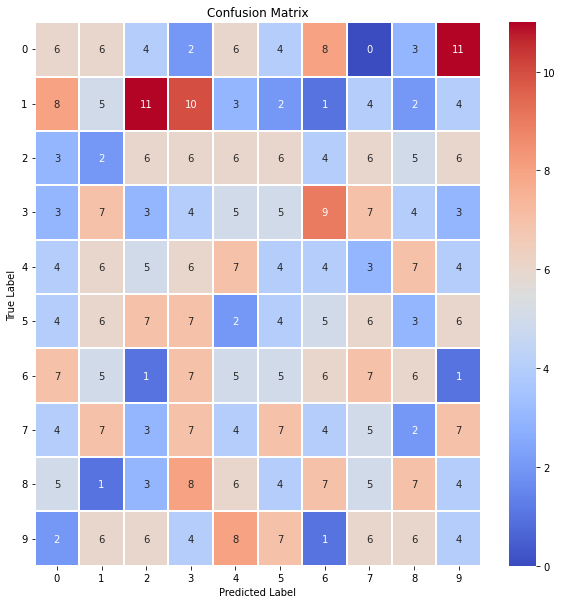

              precision    recall  f1-score   support

           0       0.13      0.12      0.12        50
           1       0.10      0.10      0.10        50
           2       0.12      0.12      0.12        50
           3       0.07      0.08      0.07        50
           4       0.13      0.14      0.14        50
           5       0.08      0.08      0.08        50
           6       0.12      0.12      0.12        50
           7       0.10      0.10      0.10        50
           8       0.16      0.14      0.15        50
           9       0.08      0.08      0.08        50

    accuracy                           0.11       500
   macro avg       0.11      0.11      0.11       500
weighted avg       0.11      0.11      0.11       500



In [48]:
compute_and_show_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

### Something went wrong?

Possible cause - ds_test_preprocessed stream contains **shuffle()** stage. 

**TODO 4.3.5** prepare a Dataset ```ds_test_validation```, which does not involve reoredring images (but transforms them to correct size and correctly prepare batches). Then repeat evaluation steps. 

In [49]:
rotate = layers.Resizing(320, 320)
rescale = layers.Rescaling(1./255)

ds_test_validation = ds_test.map(lambda x, y: (rescale(rotate(x)), y)).batch(128)

In [50]:
#compute y_pred using ds_test_validation

probs = model.predict(ds_test_validation)
print(f'{probs.shape}')
y_pred = np.argmax(probs,axis=1)

(500, 10)


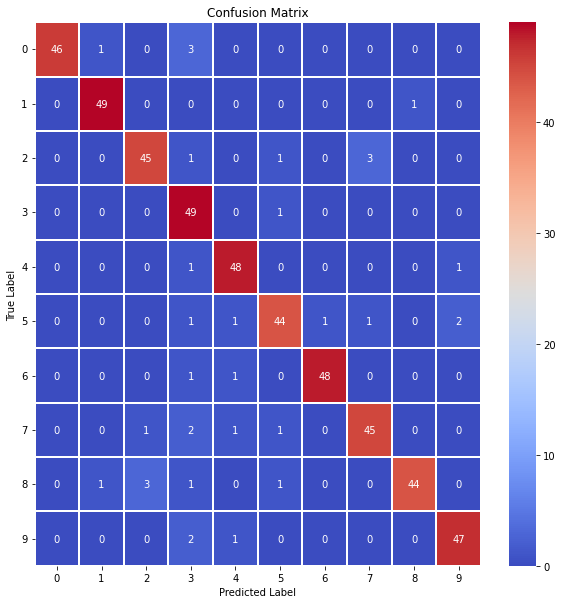

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        50
           1       0.96      0.98      0.97        50
           2       0.92      0.90      0.91        50
           3       0.80      0.98      0.88        50
           4       0.92      0.96      0.94        50
           5       0.92      0.88      0.90        50
           6       0.98      0.96      0.97        50
           7       0.92      0.90      0.91        50
           8       0.98      0.88      0.93        50
           9       0.94      0.94      0.94        50

    accuracy                           0.93       500
   macro avg       0.93      0.93      0.93       500
weighted avg       0.93      0.93      0.93       500



In [51]:
compute_and_show_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))